<a href="https://colab.research.google.com/github/tdiggelm/nn-experiments/blob/master/attention_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [143]:
n_samples = 5000
numbers = np.random.normal(0, 1, (n_samples, 3))
totals = np.sum(numbers, axis=1)
labels = np.array(totals > 0, dtype='int32')
noise = np.random.normal(0, 1, (n_samples, 10))
data = np.concatenate([numbers, noise], axis=1)
index = np.arange(data.shape[1])
np.random.shuffle(index)
rev_index = np.zeros_like(index)
for i, pos in enumerate(index):
  rev_index[pos] = i
data = data[:, index]

X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=False)
print('relevant numbers for classification in columns: %s' % 
        ', '.join(str(i) for i in rev_index[:3]))

relevant numbers for classification in columns: 8, 1, 5


In [0]:
USE_ATTENTION = True
inputs = layers.Input(shape=(data.shape[1],))
x = inputs
if USE_ATTENTION:
  attention_dense = layers.Dense(1024, activation='relu')(inputs)
  attention_dense = layers.Dropout(0.5)(attention_dense)
  attention_probs = layers.Dense(data.shape[1], activation='softmax', name='attention_probs')(attention_dense)
  x = layers.Multiply()([inputs, attention_probs])
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=18, verbose=1)

Train on 3750 samples, validate on 1250 samples
Epoch 1/18
3750/3750 [==============================] - 3s 711us/step - loss: 0.3548 - acc: 0.8749 - val_loss: 0.1398 - val_acc: 0.9640
Epoch 2/18
3750/3750 [==============================] - 1s 162us/step - loss: 0.1238 - acc: 0.9555 - val_loss: 0.1204 - val_acc: 0.9600
Epoch 3/18
3750/3750 [==============================] - 1s 170us/step - loss: 0.1068 - acc: 0.9573 - val_loss: 0.1125 - val_acc: 0.9520
Epoch 4/18
3750/3750 [==============================] - 1s 161us/step - loss: 0.0900 - acc: 0.9667 - val_loss: 0.1028 - val_acc: 0.9584
Epoch 5/18
3750/3750 [==============================] - 1s 173us/step - loss: 0.0944 - acc: 0.9651 - val_loss: 0.0873 - val_acc: 0.9600
Epoch 6/18
3750/3750 [==============================] - 1s 172us/step - loss: 0.0794 - acc: 0.9696 - val_loss: 0.0838 - val_acc: 0.9632
Epoch 7/18
3750/3750 [==============================] - 1s 171us/step - loss: 0.0731 - acc: 0.9717 - val_loss: 0.1269 - val_acc: 0.9488


Text(0.5, 0, 'epoch')

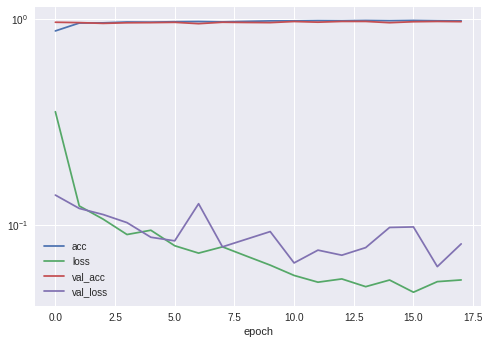

In [146]:
ax = pd.DataFrame(history.history).plot(logy=True)
ax.set_xlabel("epoch")

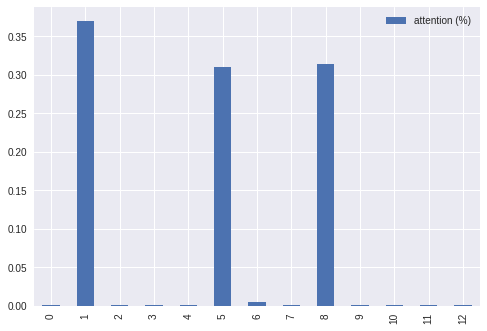

In [147]:
model_activations = models.Model(inputs, attention_probs)
activations = model_activations.predict(X_test).mean(axis=0)
pd.DataFrame(activations, columns=['attention (%)']).plot(kind='bar')